In [1]:
import sys,os
sys.path.append(os.pardir)
from common.util import im2col
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
import pickle
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

In [14]:
#Convolution 합성곱 계층 클래스.
class Convolution:
    # weight, bias , 행렬곱을 건너뛰는 폭, 출력층을 조절하기 위한 padding
    def __init__(self,W,b,stride=1,pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    
    # 순방향으로의 계산
    # 출력층 길이 = (입력층 길이 + 2*Padding - 필터(커널)의 길이 + 1)  / stride(폭)  
    def forward(self,x):
        
        # 한개의 필터는 3차원!!
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 출력 height, width 계산
        out_h = int(1+(H + 2*self.pad - FH) / self.stride)
        out_w = int(1+(W + 2*self.pad - FW) / self.stride)
        
        # x의 합성곱할 배열들을 2차원으로 핀다.
        # row당 한 이미지의 한 필터에 곱해질 조각을 가로 -> 세로 -> 채널 순서대로 편다. 한개의 필터는 3차원이다!
        # 한 행의 길이(열)은 FH*FW*C
        # 행의 개수는 out_w * out_h * N
        col = im2col(x,FH,FW,self.stride,self.pad)
        
        # 필터를 2차원 배열로 핀다.
        # row당 한개의 필터! 가로 -> 세로 -> 채널 순으로 편다.
        # 한 행의 길이(열)은 FH*FW*C
        # 행의 개수는 FN 필터의 개수!
        # x는 각 필터와 합성곱이므로, 전치시켜 행과 열을 바꿔준다!, x의 한 행이 필터와 대응되는 부분이므로 행*열을 맞춰준다는 느낌!
        col_W = self.W.reshape(FN,-1).T
        
        # 미시 부분 부터 보면,  각 필터  -> stribe 가로이동 -> stribe 세로이동 -> 다음 이미지 이동,, (필터와 합성곱시 모든 채널이 동시에됨) 
        out = np.dot(col,col_W) + self.b
        
        # 거시부분부터 순서대로 reshape해야 알맞는 순서의 값이 떨어진다. 이미지 개수, 세로 개수, 가로개수, 필터 개수 4차원으로 만든다.
        # (N,FN,out_h,out_w)로 전치시킨다.!!
        out = out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)
        
        # 순전파를 돌며 중간데이터 저장.
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    #역전파!
    # 채널 위치를 바꾸고 reshape
    # 반대로 역전파 계산!!
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        
        # 다시 행렬곱을 해야하므로 N, out_h, out_w, FN  순으로 전치!
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        # 각 필터마다 bias의 미분값
        self.db = np.sum(dout, axis=0)
        
        # dout은 이 노드 출력값에 대한 미분값!!  == 다음 노드의 입력값에 대한 미분값!
        self.dW = np.dot(self.col.T, dout)
        # FN이 가장 마지막 차원의 배열법 이었으므로, FN을 가장 처음 차원으로 나열하기 위해 전치를 먼저한다.
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        # 입력값에 대한 미분을 구한후
        dcol = np.dot(dout, self.col_W.T)
        # 이차원 배열을 im형태의 나열들인 4차원 형태로 바꿔준다.!
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        # 입력값에 대한 미분값을 dout으로 전달해준다.!! (전 노드 입장에서 출력값= 현 노드에서의 입력값) 전노드 출력에 대한 미분값이므로!!
        return dx
    
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 각 row는 풀링 대상의 뭉터기(필터에 곱해지는 조각과 같은 개념)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # 같은 채널끼리 다른 row로 만들기 위해서 reshape한다.
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 1을 축으로 생긴 배열(0축 일차원 배열)중 max값을 구한다. 최대풀링!!
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 다시 4차원으로 reshape, 미니배치 개수, 채널수(필터의 수), 높이, 너비
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        # 최대 풀링을 하며 사라진 부분을 생성한다. -> pool_size중 한개씩만 살아났으므로 pool_size만큼 row를 증가시켜준다.!
        dmax = np.zeros((dout.size, pool_size))
        
        # 최대 풀링으로 선택됬던 인덱스들은 원래 값을 가지고,
        # 선택되지 않았던 값들은 증가량(미분값)에 아무 영향이 없으므로 0이 배정된다.
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        # tuple concatenate..3차원이 pool size 만큼의 영역만큼 한차원이 더 늘어남,, 4차원이 되었다!!
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        # Pool size를 한 행으로한 이차원 배열을  다시 이미지의 task개수 차원(4차원)으로 고쳐준다!!
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [2]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 랜덤값 표준편차로 가중치 초기화
        self.params = {}
        # 첫 convolution 층 30 * (1*5*5) 필터 매개변수 초기화
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # 두번째, affine 계층 (은닉층 hidden)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # 마지막, affine 계층 (출력층 out)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()

    #순전파를 통한 예측값!
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        #마지막 layer는 softmax와 entropy 손실 함수
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    # 수치미분은 너무 오래걸림....
    # 각 노드마다 모델의 미분값을 계산해줘야함..
    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        
        # 거꾸로 미분값을 전달한다.!!
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    
    #pickle 모듈을 통해 매개변수 dict정보를 저장한다.!
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    #pickle 파일을 역직렬화!
    # pickle의 dict 객체안의 weight와 bias를 추출해 넣음
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
            
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [24]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

In [17]:
# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

# 신경망 생성!
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 학습!! Adam방식으로 가중치를 조절                      
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:2.300655641069292
=== epoch:1, train acc:0.279, test acc:0.251 ===
train loss:2.299292588216758
train loss:2.2953971549442964
train loss:2.2912435234090807
train loss:2.2858804349218214
train loss:2.2735317961508126
train loss:2.2660419913945686
train loss:2.2488359221780585
train loss:2.225820420608649
train loss:2.207624452043262
train loss:2.162213112807669
train loss:2.1586549077537907
train loss:2.094188619336583
train loss:2.0246618577719158
train loss:2.0200933509206824
train loss:1.94363137103893
train loss:1.920221391511597
train loss:1.8112959545237748
train loss:1.781460066129203
train loss:1.611475527922119
train loss:1.6147034286914086
train loss:1.5097716502558174
train loss:1.3506294404018184
train loss:1.463793414877363
train loss:1.1533362609525133
train loss:1.1991363417659644
train loss:1.1676850300079886
train loss:1.0682964287611336
train loss:1.0433177115286456
train loss:0.8725685811690818
train loss:0.8752342838808768
train loss:0.9570404720854679
tra

train loss:0.12310573521824042
train loss:0.28925838476444815
train loss:0.33844518313740046
train loss:0.2657189228384135
train loss:0.1912975883371148
train loss:0.3225948985875759
train loss:0.2969991827672949
train loss:0.2802766186348951
train loss:0.21134368912909626
train loss:0.18473371945678863
train loss:0.22257744660951478
train loss:0.23134887579189622
train loss:0.17585927873822474
train loss:0.24602153149049802
train loss:0.16415427261289064
train loss:0.190303819133674
train loss:0.1797251068572095
train loss:0.19755335229215493
train loss:0.2359630396949418
train loss:0.1509240541624295
train loss:0.146899129080415
train loss:0.3446992865392117
train loss:0.18768242806233634
train loss:0.1303883157285828
train loss:0.38259279246233757
train loss:0.35171847661595934
train loss:0.1260467300576185
train loss:0.26159176101280046
train loss:0.22774116129529395
train loss:0.17523191809079092
train loss:0.13540856328672024
train loss:0.14896692618440022
train loss:0.1655973439

train loss:0.08241819205564678
train loss:0.0971709064596492
train loss:0.10439193386343307
train loss:0.12868052441200878
train loss:0.10118888494661071
train loss:0.1677051872682355
train loss:0.1303922726821799
train loss:0.14981013257028253
train loss:0.17174969007131544
train loss:0.13524129277321112
train loss:0.10862095112618542
train loss:0.1410436769826582
train loss:0.1044717158435524
train loss:0.21827641800535091
train loss:0.08518328341475334
train loss:0.2410301140578933
train loss:0.1526690018987355
train loss:0.04820983953363421
train loss:0.08979830613328771
train loss:0.06951055349277035
train loss:0.058793264252804074
train loss:0.17634705674031398
train loss:0.13102074970432148
train loss:0.13219436027209042
train loss:0.08229597799315909
train loss:0.14496114970615825
train loss:0.170705747468521
train loss:0.06638889427592169
train loss:0.1137166804995608
train loss:0.130873667800956
train loss:0.10118187796851781
train loss:0.1556696212579503
train loss:0.0751269

train loss:0.24157624621895088
train loss:0.11298339674532068
train loss:0.1597833314687887
train loss:0.15020775109587886
train loss:0.17680333071838433
train loss:0.17001121167481226
train loss:0.07316080666223865
train loss:0.06961993045501229
train loss:0.13755045056124263
train loss:0.08184103527370876
train loss:0.08088098666736394
train loss:0.030399669468156542
train loss:0.08896649926949138
train loss:0.1062073945060857
train loss:0.06421388658653333
train loss:0.0898973581157116
train loss:0.15434223848827147
train loss:0.13997041622543885
train loss:0.2015522773685609
train loss:0.0399163394040216
train loss:0.09351637671260743
train loss:0.08284225279957237
train loss:0.12773445554740853
train loss:0.048538575120265576
train loss:0.05337236113246692
train loss:0.06956053491376911
train loss:0.03998212198884594
train loss:0.1622124816897093
train loss:0.11852339493563438
train loss:0.0515182082450062
train loss:0.07824621202624554
train loss:0.16273996476612093
train loss:0.

train loss:0.017626123320398198
train loss:0.05031645057683876
train loss:0.07501481071857419
train loss:0.08931306480327017
train loss:0.04362803032608645
train loss:0.038482191055898826
train loss:0.09611270525653783
train loss:0.11968786325318892
train loss:0.08446475589798157
train loss:0.05674530480135229
train loss:0.056676678952304285
train loss:0.10940746455950373
train loss:0.08965453683883688
train loss:0.1428242982575983
train loss:0.1329861842610336
train loss:0.0523305436231568
train loss:0.09126180260348984
train loss:0.09607028911232128
train loss:0.06848425103396934
train loss:0.03629620773842521
train loss:0.2362648253562618
train loss:0.082003473880685
train loss:0.06608290084658434
train loss:0.08260066239116595
train loss:0.08358054058088085
train loss:0.0315383460751889
train loss:0.04842500240786622
train loss:0.03707024053910959
train loss:0.04496452989523776
train loss:0.031364879148458216
train loss:0.09359155347530639
train loss:0.0652847114730945
train loss:0

train loss:0.021007681558372376
train loss:0.06481621443733743
train loss:0.04718869172646909
train loss:0.13177885373908424
train loss:0.048136608243730505
train loss:0.032493007921166085
train loss:0.04968719880973278
train loss:0.04689878629277851
train loss:0.07147813082912634
train loss:0.020012235445669563
train loss:0.10191839418262427
train loss:0.03261706610852809
train loss:0.035065894161623805
train loss:0.02389255573997386
train loss:0.0748415261106655
train loss:0.02110155801675405
train loss:0.03008949798582306
train loss:0.06315111519922297
train loss:0.050082595380098745
train loss:0.06128757683789545
train loss:0.02952580584887459
train loss:0.023784433541000773
train loss:0.030093722165660926
train loss:0.055236441316318156
train loss:0.026358030940765984
train loss:0.08917537714418484
train loss:0.054255071089581934
train loss:0.04999583901386364
train loss:0.01951656264035128
train loss:0.1250161639286268
train loss:0.012275950106142462
train loss:0.0678930747652215

train loss:0.04976573658428313
train loss:0.008829811732685867
train loss:0.06427968278271401
train loss:0.019919489709176473
train loss:0.04660840451997175
train loss:0.05432921970386488
train loss:0.03932069355751156
train loss:0.08043208227406147
train loss:0.015831522727576593
train loss:0.1091500518759359
train loss:0.021986555176080568
train loss:0.053377646354124696
train loss:0.10896425967293594
train loss:0.07283459416675475
train loss:0.020286415870570926
train loss:0.09802915980235521
train loss:0.04984343699312434
train loss:0.0641035505892889
train loss:0.06863877285711836
train loss:0.07115123930759393
train loss:0.09449550755641561
train loss:0.0547933417862237
train loss:0.019176206321794766
train loss:0.01859300473950227
train loss:0.09500669932793575
train loss:0.055969593640305425
train loss:0.07564415326628998
train loss:0.014362760766636527
train loss:0.006095695551805916
train loss:0.033820282740850055
train loss:0.025409427540887704
train loss:0.03779743359112837

train loss:0.030272694307823356
train loss:0.09492487805277479
train loss:0.023229984911140044
train loss:0.06554982974679983
train loss:0.013147330367937048
train loss:0.026008180002791842
train loss:0.03735836457298627
train loss:0.02507846581602266
train loss:0.06888369170870863
train loss:0.011778978951638687
train loss:0.01752504370371499
train loss:0.03322268330862643
train loss:0.05038750671379691
train loss:0.013770567553853223
train loss:0.031182217796470166
train loss:0.009659932269306311
train loss:0.010130641518055962
train loss:0.0475072918510301
train loss:0.19198892686572758
train loss:0.03284965041290854
train loss:0.031673065623184324
train loss:0.0619058320912244
train loss:0.007706694228549654
train loss:0.03209808027150035
train loss:0.04378669323112396
train loss:0.04913675759945606
train loss:0.027847838459026913
train loss:0.07062227825666813
train loss:0.1061290868325521
train loss:0.017835285149019536
train loss:0.06306266045006759
train loss:0.0933172892225877

train loss:0.022449914803148178
train loss:0.036525350625914645
train loss:0.06621557378362758
train loss:0.11556362611745899
train loss:0.028248388463598853
train loss:0.05308574785873036
train loss:0.06711103258349317
train loss:0.03247978711625023
train loss:0.027105511938361367
train loss:0.010103835651106799
train loss:0.025380025565676548
train loss:0.0148402768394183
train loss:0.02425324427472591
train loss:0.00932047351816121
train loss:0.056268031278218424
train loss:0.06437246532854786
train loss:0.021847319417200764
train loss:0.041888204154201414
train loss:0.016729924965228498
train loss:0.07650952584130928
train loss:0.03084018955318692
train loss:0.006590430116588596
train loss:0.03911047998873443
train loss:0.013965246435857831
train loss:0.016320033715647025
train loss:0.04553328880264334
train loss:0.008417266134962431
train loss:0.07526366763477807
train loss:0.013404266032563596
train loss:0.016491911643721636
train loss:0.010065389599335072
train loss:0.0320030781

train loss:0.05167593728009119
train loss:0.01292495728511792
train loss:0.015217392613643885
train loss:0.03060781599042339
train loss:0.08946389290716071
train loss:0.02802863982615942
train loss:0.01765333350814213
train loss:0.03663135691195194
train loss:0.01584074427751046
train loss:0.05802862297862733
train loss:0.03527114954641727
train loss:0.0026112525661768863
train loss:0.007050227018109804
train loss:0.023253854729410498
train loss:0.009064506487280357
train loss:0.03606146192424441
train loss:0.024155284232885404
train loss:0.058166295365041164
train loss:0.007605562397328963
train loss:0.014651069560927633
train loss:0.0046472685171384765
train loss:0.05127490367108505
train loss:0.00904192146167642
train loss:0.014242820429431653
=== epoch:5, train acc:0.986, test acc:0.986 ===
train loss:0.07218989422401169
train loss:0.07821826770793368
train loss:0.008142683925473427
train loss:0.0033668696868843027
train loss:0.08724323148000154
train loss:0.01008341730822661
train

train loss:0.03313306530492328
train loss:0.0347743792824427
train loss:0.040458229560465096
train loss:0.018050535039685397
train loss:0.0037794093248719853
train loss:0.01638929247797525
train loss:0.03310876331894515
train loss:0.0509622254031082
train loss:0.01739568069369627
train loss:0.0027189783418873174
train loss:0.03041538691158629
train loss:0.01173192616302599
train loss:0.016655405175710385
train loss:0.012723835598600786
train loss:0.05977627872955513
train loss:0.017026674750367975
train loss:0.008020596411315086
train loss:0.06712634892784329
train loss:0.005410381078339299
train loss:0.03636995915272296
train loss:0.03742095546554757
train loss:0.0374138470981875
train loss:0.014464317599166544
train loss:0.00810017078247474
train loss:0.0045840430459381225
train loss:0.025052062269551766
train loss:0.02689128494355083
train loss:0.035081609322624586
train loss:0.014069798352205017
train loss:0.012959866043343024
train loss:0.03696061014926351
train loss:0.03947974807

train loss:0.02437063751098686
train loss:0.0023940953671437535
train loss:0.06069119158785373
train loss:0.014940591495148951
train loss:0.0023911416573051685
train loss:0.02683746114871026
train loss:0.023792583621204014
train loss:0.02493906634510705
train loss:0.03945959935461042
train loss:0.006629341020930819
train loss:0.03575228128795791
train loss:0.024064677401968066
train loss:0.009415693546436588
train loss:0.013919947405251551
train loss:0.05183404459441931
train loss:0.03505001093839302
train loss:0.014517197272228182
train loss:0.006006202055766323
train loss:0.02388544101649146
train loss:0.020246519539310066
train loss:0.043784141814809406
train loss:0.021504635233157852
train loss:0.007415646629129706
train loss:0.011552332269419669
train loss:0.013935801042648537
train loss:0.013970350068628465
train loss:0.01515400042980385
train loss:0.04711196780168754
train loss:0.014045237506258435
train loss:0.0346653931944565
train loss:0.00968742671680068
train loss:0.0202201

train loss:0.06052620250893266
train loss:0.010112752180465135
train loss:0.011765161747893906
train loss:0.10793331415267493
train loss:0.0266051829950093
train loss:0.021193795473693003
train loss:0.0142609400365294
train loss:0.01289143974150092
train loss:0.00650072167495758
train loss:0.07565854762737236
train loss:0.011463967362530135
train loss:0.04590594065514919
train loss:0.015866426040183897
train loss:0.014859110885330344
train loss:0.025772080266060846
train loss:0.019354428667350876
train loss:0.021920913880094903
train loss:0.02334542898838376
train loss:0.036133175492641
train loss:0.005932756920391789
train loss:0.008437307119672364
train loss:0.013640286738636155
train loss:0.025044547544507908
train loss:0.020616311998189453
train loss:0.03222903080853067
train loss:0.009569506319726069
train loss:0.03367481080097631
train loss:0.06913825793939651
train loss:0.027768168021947766
train loss:0.04556951672053648
train loss:0.010465522565566597
train loss:0.0077588102452

train loss:0.021393713811861847
train loss:0.08341862918869794
train loss:0.016655798126866208
train loss:0.005717524065638693
train loss:0.006974396302201053
train loss:0.030918143914866962
train loss:0.013864534184731358
train loss:0.028259415331414788
train loss:0.004771645009695708
train loss:0.00957144025653898
train loss:0.025044486473136052
train loss:0.03158724324659773
train loss:0.04996237754305241
train loss:0.0052802830602455475
train loss:0.00584376176573285
train loss:0.023949810344661357
train loss:0.03935892228749392
train loss:0.030244637342813508
train loss:0.09906028620459457
train loss:0.011463799428410809
train loss:0.012495262318898224
train loss:0.019664723570566468
train loss:0.021054612721842343
train loss:0.02700241209617541
train loss:0.010588557162667933
train loss:0.030767654147002724
train loss:0.015618371475245363
train loss:0.050326626029559486
train loss:0.018145498707357027
train loss:0.013259266576457231
train loss:0.04536036760459056
train loss:0.020

train loss:0.02094063495373778
train loss:0.013888148951506822
train loss:0.05269655481645823
train loss:0.029867596957305804
train loss:0.009775016146989543
train loss:0.010676419374352358
train loss:0.016046906905438436
train loss:0.06323381183222422
train loss:0.012029943231113817
train loss:0.011197677047495627
train loss:0.012861950978494609
train loss:0.008781474556923132
train loss:0.049350168598184564
train loss:0.030417284782810677
train loss:0.009295115460937347
train loss:0.016086238441998427
train loss:0.009139962268898953
train loss:0.015035705392828193
train loss:0.004098758370722783
train loss:0.022036121947660473
train loss:0.010518812110675464
train loss:0.01254223142203953
train loss:0.015795741226067167
train loss:0.0037193995252272297
train loss:0.0186344790834186
train loss:0.005296042077084213
train loss:0.04135200941743997
train loss:0.030151927376008327
train loss:0.008517940465354968
train loss:0.010998655009717391
train loss:0.015069028280821522
train loss:0.0

train loss:0.024527004264349426
train loss:0.046076735300650505
train loss:0.07683155997429074
train loss:0.006141043828720683
train loss:0.01798198116986927
train loss:0.014127996811405853
train loss:0.0023992799048553185
train loss:0.0012417992486017562
train loss:0.006242212846199474
train loss:0.0049665641996681316
train loss:0.03460308670141566
train loss:0.024775739298508816
train loss:0.0022760378109458754
train loss:0.007035854911509947
train loss:0.010025629062342134
train loss:0.018921908613107837
train loss:0.003566005080216384
train loss:0.009764877679634744
train loss:0.003966379857907436
train loss:0.03394489874900095
train loss:0.0211642902613477
train loss:0.016141692554835697
train loss:0.00867861721720626
train loss:0.06373102921977458
train loss:0.03707362556695376
train loss:0.011183389472479906
train loss:0.011243300064102775
train loss:0.025292869016130367
train loss:0.03097422097366399
train loss:0.030751769608782408
train loss:0.011875995357144297
train loss:0.0

train loss:0.017518493186066037
train loss:0.008697953569494252
train loss:0.016386571938138052
train loss:0.020073703280424265
train loss:0.006126281333525354
train loss:0.006658573674584702
train loss:0.004530847727057823
train loss:0.005387524880680723
train loss:0.0370910557792594
train loss:0.01633939342898553
train loss:0.0073450173715993265
=== epoch:8, train acc:0.99, test acc:0.983 ===
train loss:0.0023247932817519424
train loss:0.009276114621707571
train loss:0.01292286530748566
train loss:0.03742944112470701
train loss:0.012684693138961365
train loss:0.004493136379895561
train loss:0.06538233081245379
train loss:0.019274319701593542
train loss:0.04723056283497834
train loss:0.008525407122304388
train loss:0.019118055973425627
train loss:0.019604211783638237
train loss:0.006908541869342194
train loss:0.0023214577757135336
train loss:0.0011275570725998052
train loss:0.0318304861792964
train loss:0.0034182986433234203
train loss:0.013634444975001315
train loss:0.016691183854124

train loss:0.0019777567368512708
train loss:0.0010290504557640926
train loss:0.0175453801790154
train loss:0.003140184784213165
train loss:0.013836229551102707
train loss:0.004895421329584711
train loss:0.016053630272236174
train loss:0.013247416062457077
train loss:0.0041602617902370955
train loss:0.04067622623466855
train loss:0.03190682093481525
train loss:0.006284652283345574
train loss:0.000977904796018854
train loss:0.004379237830700523
train loss:0.03788190418060508
train loss:0.0037547201184224633
train loss:0.0029585307104710657
train loss:0.003813038822183096
train loss:0.019463430390488968
train loss:0.015260961546858133
train loss:0.0028326659339484163
train loss:0.007972373248726562
train loss:0.0019208368615977682
train loss:0.006114894042368903
train loss:0.11209825645601107
train loss:0.00984452701957668
train loss:0.013949407138740117
train loss:0.007021970834568759
train loss:0.006179822934261845
train loss:0.016209168402146815
train loss:0.004344361239695644
train lo

train loss:0.01924018263022133
train loss:0.005190943050685039
train loss:0.02118875544803202
train loss:0.013284561362419138
train loss:0.02483235020735608
train loss:0.00992805903122615
train loss:0.006621413447530756
train loss:0.057129411064962075
train loss:0.0015567056721249772
train loss:0.0015056299705120996
train loss:0.019410936556534752
train loss:0.004511612624718871
train loss:0.017126308197799624
train loss:0.03407199918018
train loss:0.0031291294083261524
train loss:0.03090416525008384
train loss:0.007948159682840869
train loss:0.007413131940601966
train loss:0.008076992542488424
train loss:0.004972778251216423
train loss:0.0481758855537695
train loss:0.010485192231732183
train loss:0.030008860283189318
train loss:0.0067858777906251245
train loss:0.0024413319762917104
train loss:0.006745518802791847
train loss:0.009556170428198918
train loss:0.007283546378785714
train loss:0.012553013349231154
train loss:0.005602275816496928
train loss:0.004015352600039388
train loss:0.0

train loss:0.013205344275818653
train loss:0.0019168256544124516
train loss:0.015079585985082324
train loss:0.010742525446107352
train loss:0.0023092553602491257
train loss:0.0029677543827659036
train loss:0.003318723604048422
train loss:0.0053432555400533465
train loss:0.011153233764371408
train loss:0.005117642408758571
train loss:0.003426705517109996
train loss:0.004078007259946446
train loss:0.0033041262092752288
train loss:0.0037688940220780755
train loss:0.005967467225471517
train loss:0.008941684208911088
train loss:0.011138757408278362
train loss:0.05558982762611033
train loss:0.0007898584122211781
train loss:0.00262154466415327
train loss:0.016818389181736195
train loss:0.0017228305408511961
train loss:0.02059406599655719
train loss:0.04383857383299698
train loss:0.0032871848342089036
train loss:0.004912504927696194
train loss:0.002389570395168734
train loss:0.011860810997646788
train loss:0.022902378726570468
train loss:0.016340963528698314
train loss:0.0018424774492003862
tr

train loss:0.0012502476963610729
train loss:0.010446588005029669
train loss:0.022394976679052662
train loss:0.010572305357002114
train loss:0.01640958535683059
train loss:0.016893766062279228
train loss:0.005328608696691583
train loss:0.008934812591310666
train loss:0.016410651185355004
train loss:0.0019599318067968254
train loss:0.011030420398297647
train loss:0.02650150109199748
train loss:0.014946707720495713
train loss:0.004740857970191448
train loss:0.0032709289201069552
train loss:0.02224189642464376
train loss:0.010837504650393954
train loss:0.0032596067427913605
train loss:0.06202897399256675
train loss:0.002887049872585562
train loss:0.019595316033879998
train loss:0.007636945512551832
train loss:0.010393456293904105
train loss:0.0015529195087326108
train loss:0.006671600994725693
train loss:0.0030369836793450945
train loss:0.015436861901710064
train loss:0.011298294031647092
train loss:0.00737708970749369
train loss:0.0049476168917277
train loss:0.03771122515619789
train loss

train loss:0.005499818515428512
train loss:0.031579419790006634
train loss:0.004020871777404088
train loss:0.09721431321409577
train loss:0.013531196010866053
train loss:0.00999105043717781
train loss:0.005950275624569695
train loss:0.0027548547267871176
train loss:0.007869468561368852
train loss:0.0137392803530415
train loss:0.0022084998255196596
train loss:0.005626188552773023
train loss:0.005208742983731985
train loss:0.00043683047475625425
train loss:0.014127432757442897
train loss:0.002061976109169686
train loss:0.004935633743984335
train loss:0.0045933025914653
train loss:0.0013845887434320464
train loss:0.0015731763306303611
train loss:0.003549851674863524
train loss:0.0058200304658589915
train loss:0.009102419314713015
train loss:0.021766539791462078
train loss:0.004153007942404998
train loss:0.010565382366604847
train loss:0.003836380756446215
train loss:0.0009193970521380858
train loss:0.002974720222751705
train loss:0.00921580461036358
train loss:0.0010840849080465476
train 

train loss:0.0032185820284581675
train loss:0.0014115938843028968
train loss:0.0005084287091692257
train loss:0.0056530901911982035
train loss:0.004710787698176046
train loss:0.008804051644558768
train loss:0.0024043075800543406
train loss:0.005447776184432129
train loss:0.0037631217177330166
train loss:0.004276620103191633
train loss:0.012897819993462602
train loss:0.0013340997026280704
train loss:0.006580127632378855
train loss:0.015278021019289278
train loss:0.002419387384646382
train loss:0.009479000644609915
train loss:0.002407342995452748
train loss:0.005478878135139872
train loss:0.00038781611006692056
train loss:0.003021025542959471
train loss:0.0006872126307686813
train loss:0.004794937332404713
train loss:0.003541777159277287
train loss:0.0005629612658533237
train loss:0.0020091693946882507
train loss:0.0028506656903834237
train loss:0.010567996192725929
train loss:0.0036665576238443776
train loss:0.0016567223651207349
train loss:0.009142329811482993
train loss:0.008384747054

train loss:0.005903936648478602
train loss:0.029452344915013987
train loss:0.00421669180444544
train loss:0.005949825744372017
train loss:0.0022477540127277236
train loss:0.0003274830671840308
train loss:0.00466076329325654
train loss:0.006268620016694323
train loss:0.0010310462974774369
train loss:0.007981971142385925
train loss:0.0014902659707446784
train loss:0.009024472959668468
train loss:0.036791654640653225
train loss:0.010225394486691273
train loss:0.017575066264222738
train loss:0.004845818152834861
train loss:0.009530380669052298
=== epoch:11, train acc:0.996, test acc:0.984 ===
train loss:0.004488103619007542
train loss:0.0059069852190770785
train loss:0.00342964607469342
train loss:0.003241860529864407
train loss:0.0018049171975049497
train loss:0.009899288984075107
train loss:0.010133952335849981
train loss:0.011009059775607032
train loss:0.010530419121610884
train loss:0.0025998925063962196
train loss:0.0031263517034759653
train loss:0.00225529015937192
train loss:0.00198

train loss:0.005948181610002946
train loss:0.004628321211883358
train loss:0.0035348755908078664
train loss:0.007898051781670322
train loss:0.0027640551708908788
train loss:0.0015381146094544968
train loss:0.0030637958806292685
train loss:0.006832799779405711
train loss:0.01441778202845296
train loss:0.014834714713441
train loss:0.0004509196605154876
train loss:0.004588117884527929
train loss:0.009388690204738348
train loss:0.002603197623086498
train loss:0.002999799012142356
train loss:0.0060211755748598396
train loss:0.002553091653571452
train loss:0.0057566598866694765
train loss:0.001665536220627921
train loss:0.012395486157399195
train loss:0.001085231970858791
train loss:0.006734217405947238
train loss:0.0006896326375003142
train loss:0.00491027186207865
train loss:0.005861138182097214
train loss:0.0020239970808061903
train loss:0.010093394253685137
train loss:0.0055070508861214595
train loss:0.001314694956944086
train loss:0.010965018742648663
train loss:0.013488473908872976
tra

train loss:0.003780133168055216
train loss:0.006304482614696535
train loss:0.000679905925201833
train loss:0.0014150333249314797
train loss:0.00024527876796858047
train loss:0.0057216523634059605
train loss:0.0015180531109031182
train loss:0.014527085227325638
train loss:0.00629781434546111
train loss:0.001926581593157074
train loss:0.018288617395385846
train loss:0.016284953165243216
train loss:0.005539210601203558
train loss:0.03666155985326692
train loss:0.013404476398448635
train loss:0.0006042103786680603
train loss:0.0037199095299887634
train loss:0.001149278185855789
train loss:0.0003269588092448952
train loss:0.002299470416712954
train loss:0.0035302118750268497
train loss:0.010264225755791024
train loss:0.00569602743723955
train loss:0.0049754478930613055
train loss:0.002711561128900164
train loss:0.0014803817130191557
train loss:0.0061258349972513225
train loss:0.0018638394335195924
train loss:0.0037278387186278727
train loss:0.0024153115747238474
train loss:0.002272614048114

train loss:0.005461709425163806
train loss:0.0024732039080163264
train loss:0.0022571858819801934
train loss:0.000449464186117178
train loss:0.006017764159634338
train loss:0.00797919841208994
train loss:0.0005868205329967112
train loss:0.026424386786644497
train loss:0.0010111714067943527
train loss:0.018392724819296036
train loss:0.0036804943964600717
train loss:0.0024157493289292177
train loss:0.006070121050475369
train loss:0.008151072168355008
train loss:0.0009355028038483353
train loss:0.002705590478484018
train loss:0.00154937861109214
train loss:0.000511599684231507
train loss:0.033391877152020744
train loss:0.0007942308772559664
train loss:0.004242076758327269
train loss:0.0017400095336912358
train loss:0.0005846998372604101
train loss:0.0006493262698256334
train loss:0.04515421219433537
train loss:0.006251862711086275
train loss:0.002464113405437422
train loss:0.009749707056208892
train loss:0.0032497991420836736
train loss:0.048259434608085634
train loss:0.000904812188323147

train loss:0.0018013325536464402
train loss:0.006278281975360884
train loss:0.0013490348926436374
train loss:0.002167294397656668
train loss:0.0007732662889236971
train loss:0.0030831896286919276
train loss:0.003051574317995883
train loss:0.024628430279300652
train loss:0.0030788285269357264
train loss:0.0010832017449625988
train loss:0.00276290713644812
train loss:0.030661734732670833
train loss:0.0020219530453859237
train loss:0.0027042871023683045
train loss:0.022452507533864897
train loss:0.002503490311661444
train loss:0.00287800753568843
train loss:0.0032218275306349882
train loss:0.0018294584733307931
train loss:0.006796210319209698
train loss:0.001316502648624817
train loss:0.0007547505243513351
train loss:0.001231248051549314
train loss:0.0026322604232684667
train loss:0.005395929382214247
train loss:0.0014374487583817045
train loss:0.005915122541628845
train loss:0.04388736745986707
train loss:0.0007870598698173993
train loss:0.003324094356496661
train loss:0.0027028367623888

train loss:0.0006808654822735586
train loss:0.001329868853710151
train loss:0.0011015458489984076
train loss:0.004802076229779806
train loss:0.012782342774948618
train loss:0.00771841682630963
train loss:0.0045058620032833435
train loss:0.040607662956949724
train loss:0.006178433855342616
train loss:0.01968499688859595
train loss:0.0024173493603489075
train loss:0.011063298593686181
train loss:0.012052179392075731
train loss:0.0017173197946910757
train loss:0.008422623687097487
train loss:0.00031052750608729875
train loss:0.0025208125865148418
train loss:0.0014272648076717716
train loss:0.00867816795573266
train loss:0.018560473331616735
train loss:0.020681862049794296
train loss:0.004088760108663605
train loss:0.0095659198447549
train loss:0.0025859380124862636
train loss:0.003010607961092855
train loss:0.0024790817317279002
train loss:0.0036113378125521294
train loss:0.0024157887118577133
train loss:0.00024906967638950347
train loss:0.006013723477083277
train loss:0.00033322421182210

train loss:0.00543081885657165
train loss:0.010451211949917567
train loss:0.002203268946941861
train loss:0.034276326757843256
train loss:0.006253426270926959
train loss:0.00030115800187432854
train loss:0.006705634809854123
train loss:0.0005928179021733891
train loss:0.0026697375775472953
train loss:0.0019792902136759696
train loss:0.0013791754634996478
train loss:0.0008322527628438258
train loss:0.0044473775310759954
train loss:0.007954642886491082
train loss:0.003979639212711418
train loss:0.0007579071659447893
train loss:0.00586762265744308
train loss:0.002162015588635839
train loss:0.0014831147212537477
train loss:0.001304103245858636
train loss:0.016031095020801592
train loss:0.003995520520247077
train loss:0.0008034620442059595
train loss:0.01671816876639716
train loss:0.006292898890153426
train loss:0.000664195433713887
train loss:0.0005067553973649382
train loss:0.003390348458812642
train loss:0.006390118225876844
train loss:0.0012234860433564386
train loss:0.00232262697359372

train loss:0.000487291104422635
train loss:0.0003598862348881756
train loss:0.003393157249281629
train loss:0.005290947865777794
train loss:0.00025509438337857594
train loss:0.0022183374481121333
train loss:0.006908355485216482
train loss:0.00016204982375725153
train loss:0.00440263473688203
train loss:0.005066244267734442
train loss:0.0004397615923746949
train loss:0.001565880874808063
train loss:0.0008456858684938213
train loss:0.0028629510212110063
train loss:0.0025714877535218976
train loss:0.0007127287117073535
train loss:0.01124270149568072
train loss:0.0010497697771305685
train loss:0.0006983639404804474
train loss:0.006950580886857259
train loss:0.00038298520882948064
train loss:0.003714388976541046
train loss:0.003991814761681212
train loss:0.0019628447762824247
train loss:0.0007484508208572549
train loss:0.0011499099462660013
train loss:0.0020013232384041182
train loss:0.006304436861141352
train loss:0.008320002948869299
train loss:0.00025603608481428164
train loss:0.00874707

train loss:0.013261930998596181
train loss:0.00031183014687134134
train loss:0.0005749764803053941
train loss:0.011990106651859324
train loss:0.0007882292804032919
train loss:0.0021545842770587633
train loss:0.0011443340175442671
train loss:0.002055751293958572
train loss:0.02168056540960311
train loss:0.0363489810027757
train loss:0.0010830240000277577
train loss:0.0008203251291349613
train loss:0.005271992080615195
train loss:0.0018400145436716195
train loss:0.006215584064901485
train loss:0.0008488659749688791
train loss:0.0004607794708506595
train loss:0.003215848623636992
train loss:0.0029610252908815454
train loss:0.005994723270100256
train loss:0.0030442854392646965
train loss:0.0001356295608541473
train loss:0.0020002646936855893
train loss:0.0003234493082425306
train loss:0.004937592355367747
train loss:0.0007716410922835037
train loss:0.015297913440926274
train loss:0.0016781509438268118
train loss:0.0029648727274728536
train loss:0.0014575100725874204
train loss:0.0007626643

train loss:0.00031611985325866285
train loss:0.00016229211794111436
train loss:0.00026453223043643593
train loss:0.004399631408911727
train loss:0.0005249783063651037
train loss:0.00228387502127715
train loss:0.0018372054708932209
train loss:0.0005095543937464048
train loss:0.02984929333637078
train loss:0.003064055764764417
train loss:9.56467780185918e-05
train loss:0.0027684779343063346
train loss:0.0021343589874202144
train loss:0.0007878174740630215
train loss:0.0016569271368662001
train loss:0.0033743843573409067
train loss:0.0003397771641234594
train loss:0.0011787336667979558
train loss:0.000545572853949165
train loss:0.001514952661713106
train loss:0.011701105583034596
train loss:0.0011090937464187504
train loss:0.0035627755344568145
train loss:0.0012819838300031946
train loss:0.004738318187433012
train loss:0.0005453892994428929
train loss:0.0016444508788735954
train loss:0.0006921303158805485
train loss:0.00526358611360318
train loss:0.007906223181993965
train loss:0.01789505

train loss:0.004318632571091207
train loss:0.0006998451346727753
train loss:0.010132847219158239
train loss:0.0017785932406149195
train loss:0.0037016826635434506
train loss:0.000834306627480116
train loss:0.0006179026382500583
train loss:0.0030529497399151913
train loss:0.006064886324645115
train loss:0.000585516012747269
train loss:0.0008657272788860827
train loss:0.0014317281611056754
train loss:9.714840716853856e-05
train loss:0.0015348248440147103
train loss:0.0007535256253367933
train loss:0.0008819137849766597
train loss:0.0007860209812876114
train loss:0.0019761090954932615
train loss:0.003443987057710905
train loss:0.0006430622666168458
train loss:0.0009333637071543459
train loss:0.00019758496394973915
train loss:0.002275344419385595
train loss:0.005386652678492201
train loss:0.0008638750185170561
train loss:0.003439853165101521
train loss:0.0008955561674216616
train loss:0.00023294254110190992
train loss:0.00103689251720786
train loss:0.0002842764645333885
train loss:0.001135

train loss:0.003239681392927693
train loss:0.00491471201465748
train loss:0.004597546300137012
train loss:0.0009675535876134947
train loss:0.0010477594793196375
train loss:0.01606248022518605
train loss:0.007444869971486058
train loss:0.00018815683061153423
train loss:0.00017500725168173516
train loss:0.0004166176964397364
train loss:0.00018400746435933015
train loss:0.00454148633613781
train loss:0.002327248022816175
train loss:0.0002764923555630565
train loss:0.0019352245052062698
train loss:0.006119505070005157
train loss:0.0006132031160098516
train loss:0.0003562917629885301
train loss:0.00014481313335275162
train loss:0.004794142406061316
train loss:0.0023151218677477685
train loss:0.0032445017403267924
train loss:5.552669989885827e-05
train loss:0.0015634780528307535
train loss:0.004856953594585193
train loss:0.0014802188043378044
train loss:0.0013237784202878371
train loss:0.0026015260709446437
train loss:0.00129866144428471
train loss:0.010267924887771547
train loss:0.000835013

train loss:0.005190595143919129
train loss:0.0031669171680336404
train loss:0.002385336399889309
train loss:0.0016823395071450223
train loss:0.0011649035145457351
train loss:0.0011298572442786513
train loss:0.012807320907862291
train loss:0.0020423965787791988
train loss:0.0009166600622779192
train loss:0.0018590785213639946
train loss:0.0006326910593947277
train loss:0.000649697319849548
train loss:0.001966507736590451
train loss:0.0040392171176177084
train loss:0.004162394323265993
train loss:0.0004064799790122534
train loss:0.0029830419555968725
train loss:0.01639330252925912
train loss:0.001257621095150412
train loss:0.0011349312810133214
train loss:0.0018119321232475513
train loss:0.002335083708211781
train loss:0.002332438753006792
train loss:0.00038542518342182287
train loss:0.003578466077439841
train loss:0.0003023843220775754
train loss:0.0035051789595722006
train loss:0.0025597026393657683
train loss:0.0040873465640368575
train loss:0.0060312071570462625
train loss:0.00076349

train loss:0.00013264829668901276
train loss:0.0004702719140383291
train loss:0.00155578806799585
train loss:0.004339115503242393
train loss:0.001084872604677768
train loss:0.004386924681182743
train loss:0.002077302185224002
train loss:0.002434379655114725
train loss:0.0006630512733374329
train loss:0.008374083123147578
train loss:0.00019604021022765438
train loss:0.00060959843607126
train loss:0.004089760493509344
train loss:0.0028382961063895084
train loss:0.0014911513765336955
train loss:0.001964369588739499
train loss:0.0008100362186622108
train loss:0.0030347032824953953
train loss:0.00018738359052843396
train loss:0.003059183401092428
train loss:0.0019068348056345288
train loss:0.0017010582183844243
train loss:0.0009121981170628514
train loss:0.00031638794681333293
train loss:0.0011163864391496698
train loss:0.002663250584227292
train loss:0.0002084049661161104
train loss:0.001731797054739384
train loss:0.0005358975766534336
train loss:0.001225393970788265
train loss:0.001563171

train loss:0.00020881771977714905
train loss:0.000935054166680363
train loss:0.0003871374831081041
train loss:0.0006948438943558678
train loss:0.00318659152457777
train loss:0.0016998685650046533
train loss:0.00032632151980063246
train loss:0.0012780319222679625
train loss:0.003233556877422962
train loss:0.000471280077826808
train loss:0.003469026695281211
train loss:0.0025426160892460747
train loss:0.00011086323164115898
train loss:0.004176960155043611
train loss:0.000931114216801855
train loss:0.02845477344460061
train loss:0.0004465121093043084
train loss:0.00046523163988871854
train loss:0.0007415795359360946
train loss:0.0011509423335295196
train loss:0.00114668094938351
train loss:0.00013779194139456298
train loss:0.0007334572098242596
train loss:0.006718844205125657
train loss:0.0005092440742447009
train loss:0.0008288501552025165
train loss:0.007005707028699238
train loss:0.006768689446570351
train loss:0.0008474237447467497
train loss:0.0002249156616229032
train loss:0.0003165

train loss:0.0012265979376138805
train loss:0.0005201286119674996
train loss:0.0003058426895693413
train loss:0.0002786532002646615
train loss:0.0015196519284112274
train loss:0.0010351883014466626
train loss:0.0016371188943430123
train loss:0.0002894635235691686
train loss:0.0005959217746864293
train loss:0.0006538786036068222
train loss:0.0009508398181884693
train loss:0.0007942757255914778
train loss:0.0014646343775571217
train loss:0.0004999265399776939
train loss:0.00014237358010146862
train loss:0.001921543873503558
train loss:0.00010563656186559682
train loss:0.0014564808984861416
train loss:8.579612431932669e-05
train loss:3.784770926808747e-05
train loss:0.0006556960250507374
train loss:0.0006312071362979326
train loss:0.00048345470683214676
train loss:0.00013293175640947185
train loss:0.0010105178531891457
train loss:0.003949418989559029
train loss:0.0025441364638536827
train loss:0.0004939545196813626
train loss:0.006742028327040751
train loss:0.0004812748941399346
train los

train loss:0.0009175175170446873
train loss:8.806220043178071e-05
train loss:0.00022579466588998194
train loss:0.0001416544848357176
train loss:0.0030363844336052863
train loss:0.0014835751065330493
train loss:0.00019966928301835506
train loss:0.0019021933390838835
train loss:0.0011660537203752243
train loss:0.0002640816321595348
train loss:0.00019831521561473192
train loss:0.0028097448154180277
train loss:0.0036619458153921624
train loss:0.0013514910686876788
train loss:5.4421858791437784e-05
train loss:0.004493057863222744
train loss:0.0008305421160427156
train loss:0.00042215967223100266
train loss:0.0006163152484275151
train loss:0.0013447846506064861
train loss:0.0015285568975496062
train loss:8.893155930119063e-05
train loss:0.004276931490874955
train loss:0.0001198128341909784
train loss:0.0003815789033732665
train loss:0.0009795037505000359
train loss:0.0002246292508236546
train loss:0.00048727453193514664
train loss:0.0027728972270197804
train loss:0.0024221009597997605
train 

train loss:0.002019339079123179
train loss:0.0005461314973880783
train loss:0.0002558792335908581
train loss:1.2736644984024954e-05
train loss:0.0018237717556975055
train loss:0.0024558363294226644
train loss:0.0008575598694433504
train loss:0.00015025752971630012
train loss:0.0017901446274542758
train loss:0.00016017514381349858
train loss:0.004460126026638645
train loss:0.0011180232720290713
train loss:0.0005495301852197411
train loss:9.273743848998024e-05
train loss:0.0015126506715537997
train loss:0.0012511396800036433
train loss:0.0005890161850150211
train loss:0.001087813516746074
train loss:0.003360200122028615
train loss:0.0009007096724244173
train loss:0.0009876064857983345
train loss:5.109890313858281e-05
train loss:0.00010395600136419271
train loss:0.0028313335878578467
train loss:0.0005619022096859183
train loss:0.00029453542850871165
train loss:7.132473334915913e-05
train loss:0.0005151150386027608
train loss:4.5650155519640594e-05
train loss:0.0003211962048138339
train lo

train loss:4.4030668137102146e-05
train loss:0.0003765353020942989
train loss:0.0015542284263355727
train loss:0.00030219938454889453
train loss:0.00047222332095973895
train loss:0.01214657605256889
train loss:0.00018511552431169846
train loss:0.0016584564358498783
train loss:0.0006066067833125135
train loss:0.0026328928254210964
train loss:0.0003969514288079423
train loss:0.00027709076566318993
train loss:0.00024947523145931
train loss:0.002186878270903851
train loss:0.0005568317533726925
train loss:0.008760314590057612
train loss:0.0010573202016015946
train loss:0.00035929836019354527
train loss:0.01887332583464783
train loss:0.016956863877304246
train loss:0.0009560430681673455
train loss:0.0012075243939092236
train loss:0.000848470130011167
train loss:0.0009805975740141044
train loss:0.00033964426848378355
train loss:0.00023917992114846738
train loss:0.005890569903230514
train loss:0.0006260907706251759
train loss:0.00022991594233520604
train loss:0.0010744525995610838
train loss:0

train loss:0.001830102292016177
train loss:0.001091071411648961
train loss:0.0037289380684430167
train loss:0.002130980668260696
train loss:0.0005730228785972604
train loss:0.0015710293258883736
train loss:0.00023013480914645543
train loss:0.0020473408751026244
train loss:0.00029585511076984927
train loss:0.0004815784705308144
train loss:0.0006627789643482985
train loss:0.0003159692230629905
train loss:0.0010535194175016792
train loss:0.002968492254991681
train loss:0.0002716728896795243
train loss:0.0037086185960263007
train loss:0.0007875942825466418
train loss:0.00021318047847503844
train loss:0.0016318146907731163
train loss:0.0007445788698895113
train loss:0.001231640798257039
train loss:0.0011136101332180515
train loss:0.001448181589318702
train loss:0.0195193771845485
train loss:3.754396743579368e-05
train loss:0.002037859778462043
train loss:0.0014004036787808988
train loss:0.0003174492152212462
train loss:0.00039340811363011615
train loss:0.0013768357001466142
train loss:0.001

train loss:0.0006404933923868491
train loss:0.0023228676760306505
train loss:0.0010755764744726595
train loss:3.8057036226616865e-05
train loss:0.00020501571863713693
train loss:0.0012994624242666857
train loss:0.02133271617461245
train loss:0.0008029282544575861
train loss:3.285988710182606e-05
train loss:0.002797013409568557
train loss:0.00034905454720573847
train loss:0.00017669478236789012
train loss:6.544857921361964e-05
train loss:0.0003767108591714097
train loss:0.0008332146458229206
train loss:0.0033553506718108144
train loss:6.434394229789805e-05
train loss:0.0014511085943554561
train loss:0.0019014657765147691
train loss:0.0009747038411908042
train loss:0.003476372527074641
train loss:2.3329693596756794e-05
train loss:0.0009369313758988077
train loss:0.0065268464043857196
train loss:0.0007168733944380699
train loss:8.789447170954895e-05
train loss:5.9659591999204635e-05
train loss:0.0015138257826196135
train loss:0.0015001298161860558
train loss:7.334327023923594e-06
train lo

train loss:0.001824560868337348
train loss:0.0007339770921431252
train loss:0.0007913709275182222
train loss:0.001507685625718994
train loss:0.0004254706655886169
train loss:0.00013197324003625123
train loss:0.0034750052241538554
train loss:0.0003049450662164381
train loss:0.0017059589906651261
train loss:0.001009418681876302
train loss:0.007893377176219065
train loss:0.0006360298872935847
train loss:0.0010316579645491617
train loss:0.0031639301609663758
train loss:0.001020880638343978
train loss:0.00016581379978051244
train loss:0.0018946064673039285
train loss:0.0011523922785040977
train loss:0.0031243066050307463
train loss:0.0005245350918672337
train loss:0.0010254668561300484
train loss:0.01335793117352785
train loss:0.0023277173956332106
train loss:0.004171775972048787
train loss:0.0012357925932740474
train loss:0.004656469446650561
train loss:0.0006116642084867259
train loss:0.0014821921436155277
train loss:0.002465251844349691
train loss:0.00108823967158925
train loss:0.0058676

train loss:0.00284453654258168
train loss:0.002018901661261171
train loss:0.004121525951390186
train loss:0.00021513718462985498
train loss:0.0005353037374528047
train loss:0.00015561567863701513
train loss:0.019383514410878454
train loss:0.0007789679125536235
train loss:0.002075343482531343
train loss:0.0033742859140373682
train loss:0.0025561559972780584
train loss:5.425761869365503e-05
train loss:0.0003895919975681833
train loss:0.0009419103855715075
train loss:0.000669411530884932
train loss:0.0009390102579994347
train loss:0.0008382822330675466
train loss:0.0020276181965638517
train loss:0.00021903234022960631
train loss:0.0013471466044513655
train loss:0.00027203483534818764
train loss:0.0013479934382305302
train loss:0.0020021945414506375
train loss:0.0004589529186393488
train loss:0.0006296765562798434
train loss:0.00038305170634327757
train loss:0.0017043128460832674
train loss:0.0031410016138165757
train loss:0.007134500299637548
train loss:0.0024461982239686922
train loss:0.

train loss:0.0007502655251316445
train loss:0.001832223567931771
train loss:0.0008808048867566112
train loss:0.0005357557474761958
train loss:0.0013644022115482735
train loss:0.00048665865497656615
train loss:0.0007097573309673511
train loss:0.002808248149288876
train loss:6.885427894341074e-05
train loss:0.000297561975998592
train loss:0.0006467342267379612
train loss:0.001035735475997057
train loss:0.013515825362979588
train loss:0.0007905643972185689
train loss:0.00025866969045703877
train loss:0.003094962522567387
train loss:0.0009984627561868422
train loss:7.389450097681985e-05
train loss:0.0005486895620639652
train loss:0.000247196582046296
train loss:0.0006239433913209285
train loss:0.0009680806890156293
train loss:0.00015468837643482314
train loss:3.570312384838304e-05
train loss:0.00017930310727733308
train loss:0.0022675912829396004
train loss:0.0015660369574802566
train loss:0.0014124705105968396
train loss:0.00015278981211050237
train loss:0.003914467657222167
train loss:0.

In [18]:
# 매개변수 보존
network.save_params("mnistCNNparams.pkl")
print("Saved Network Parameters!")


Saved Network Parameters!


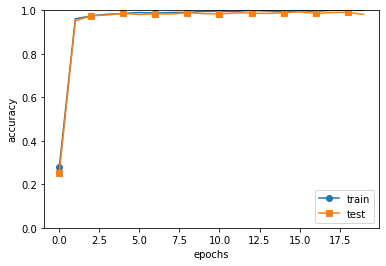

In [19]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()